In [1]:
from typing import Dict

import matplotlib.pyplot as plt
from torch import Tensor, arange, argwhere, atan2, cat, cos, diff
from torch import empty as empty_tensor
from torch import (
    float32,
    gradient,
    linspace,
    logical_and,
    meshgrid,
    norm,
    pi,
    sin,
    stack,
    tensor,
    where,
    zeros,
    zeros_like,
)
from torch.nn import functional as F

from beam_property_extract import (
    beams_boundaries_radians,
    get_beams_masks,
    get_beams_weighted_center,
    sample_ppdf_on_arc_2d_local,
)

# from convex_hull_helper import convex_hull_2d, sort_points_for_hull_batch_2d
from scanner_modeling._convex_hull._convex_hull_functions import (
    convex_hull_2d,
    sort_points_for_hull_batch_2d,
)
from scanner_modeling.geometry_2d import (
    fov_tensor_dict,
    load_scanner_layouts,
    load_scanner_geometry_from_layout,
)
from scanner_modeling._geometry_2d._utils import (
    fov_pixels_coordinates,
    fov_pixels_to_crystal_rads,
)
from scanner_modeling._plot._mpl_plot_system import (
    plot_scanner_from_vertices_2d_mpl,
    plot_polygons_from_vertices_mpl,
)
from scanner_modeling._plot._mpl_plot_ppdf import (
    plot_2d_ppdf_mpl,
)
from ppdf_io import load_ppdfs_data_from_hdf5
from beam_property_extract import (
    get_beams_weighted_center,
    get_beams_masks,
    beams_boundaries_radians,
    sample_ppdf_on_arc_2d_local,
    get_beams_angle_radian,
)

In [5]:
scanner_layouts_dir = "../../../pymatcal/scanner_layouts"
scanner_layouts_filename = (
    "scanner_layouts_e1531c3444e51439add2f18f5714fc50.tensor"
)

ppdfs_dataset_dir = "../../../pymatcal"

# Load the scanner layouts
scanner_layouts_data, filename_unique_id = load_scanner_layouts(
    scanner_layouts_dir, scanner_layouts_filename
)

# Define the Field of View (FOV) tensor dictionary


fov_dict = fov_tensor_dict(
    n_pixels=(512, 512),
    size_in_mm=(128, 128),
    center_coordinates=(0.0, 0.0),
    n_subdivisions=(4, 4),
)

In [ ]:
# Define the layout index to load
layout_idx = 0

# Load the scanner geometry
(
    plate_objects_vertices,
    crystal_objects_vertices,
    plate_objects_edges,
    crystal_objects_edges,
) = load_scanner_geometry_from_layout(layout_idx, scanner_layouts_data)

# Set the PPDFs filename for a particular scanner position
ppdfs_hdf5_filename = f"scanner_layouts_e1531c3444e51439add2f18f5714fc50_layout_0.hdf5"

# Load the PPDFs data
ppdfs = load_ppdfs_data_from_hdf5(
    ppdfs_dataset_dir, ppdfs_hdf5_filename, fov_dict
)

# Print the shapes of the loaded data
print(
    f"Layout {layout_idx}:\n"
    + f"Metal plates shape  : {list(plate_objects_vertices.shape)}\n"
    + f"Crystal shapes      : {list(crystal_objects_vertices.shape)}\n"
    + f"PPDFs data shape:     {list(ppdfs.shape)}"
)

crystal_centers = crystal_objects_vertices.mean(dim=1)
fov_corners = (
    tensor([[-1, -1], [1, -1], [1, 1], [-1, 1]]) * fov_dict["size in mm"] * 0.5
)

hull_points_batch = cat(
    (
        fov_corners.unsqueeze(0).expand(
            crystal_objects_vertices.shape[0], -1, -1
        ),
        crystal_centers.unsqueeze(1),
    ),
    dim=1,
)
hull_points_batch = sort_points_for_hull_batch_2d(hull_points_batch)
fov_points_xy = fov_pixels_coordinates(fov_dict)

Layout 0:
Metal plates shape  : [72, 4, 2]
Crystal shapes      : [864, 4, 2]
PPDFs data shape:     [864, 262144]


In [12]:
def smooth_outliers(ppdf_data_2d: Tensor, threshold: float = 1) -> Tensor:
    """
    Smooth outliers in a 2D PPDF data tensor.

    Args:
                    ppdf_data_2d (Tensor): The 2D PPDF data tensor.
                    threshold (float): The threshold for smoothing outliers.

    Returns:
                    Tensor: The smoothed PPDF data tensor.
    """

    smoothed_data = ppdf_data_2d.clone()
    outlier_indices = (ppdf_data_2d > 1).argwhere()

    smoothed_data[outlier_indices[:, 0], outlier_indices[:, 1]] = stack(
        (
            smoothed_data[outlier_indices[:, 0], outlier_indices[:, 1] - 1],
            smoothed_data[outlier_indices[:, 0], outlier_indices[:, 1] + 1],
            smoothed_data[outlier_indices[:, 0] - 1, outlier_indices[:, 1]],
            smoothed_data[outlier_indices[:, 0] + 1, outlier_indices[:, 1]],
        ),
        dim=0,
    ).mean(dim=0)
    return smoothed_data

Outlier indices: tensor([], size=(0, 2), dtype=torch.int64)


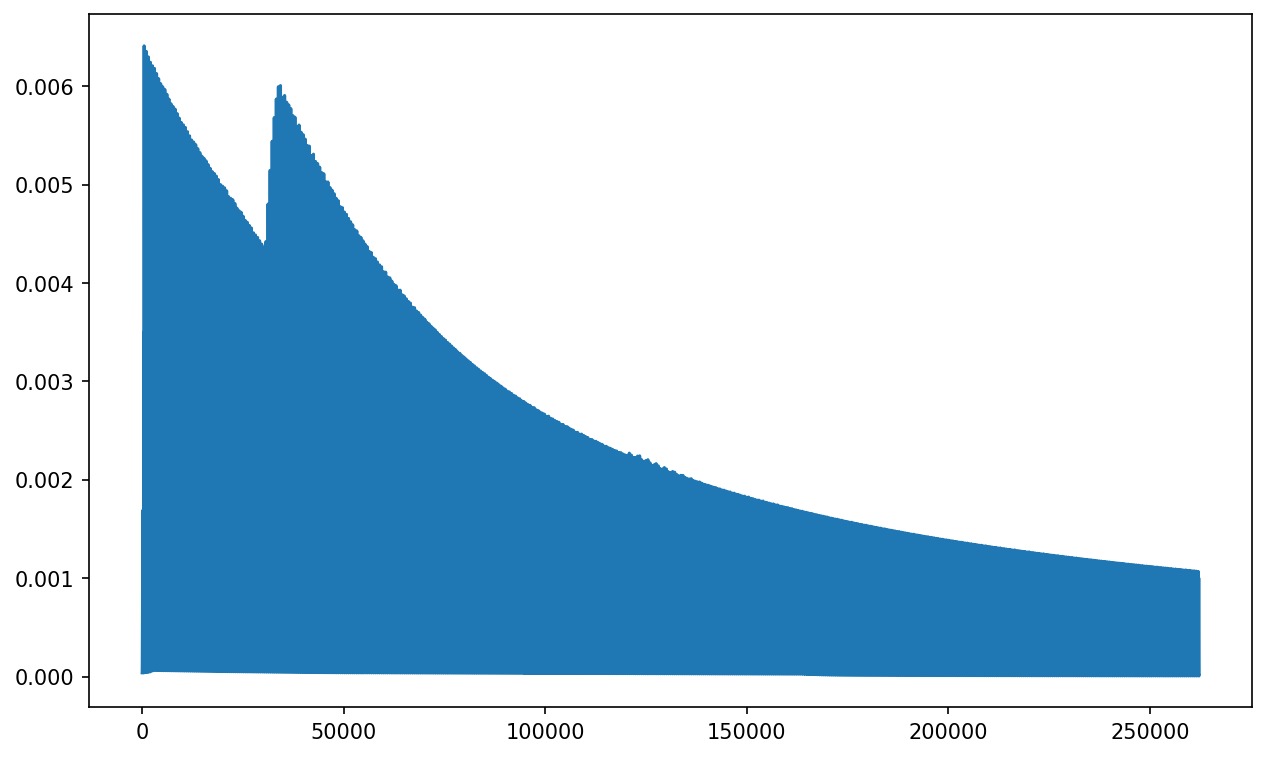

In [16]:
selected_crystal_idx = 590
fov_n_pxs = int(fov_dict["n pixels"].prod().item())
plt.close("all")
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

ppdf_data_2d = ppdfs[selected_crystal_idx].view(
    int(fov_dict["n pixels"][0]), int(fov_dict["n pixels"][1])
)
outlier_indices = (ppdf_data_2d > 1).argwhere()
# ax.plot(arange(fov_n_pxs), ppdf_data_2d.flatten(), label="PPDF data")
treated_ppdf_data_2d = smooth_outliers(ppdf_data_2d, threshold=1)
ax.plot(
    arange(fov_n_pxs),
    treated_ppdf_data_2d.flatten(),
    label="Smoothed PPDF data",
)
# print(f"Outlier indices: {outlier_indices}")
print(
    f"Outlier indices: {(treated_ppdf_data_2d>1).argwhere()}"
)

N beams: 1
Boundary 0: tensor([4.9465, 6.1020])


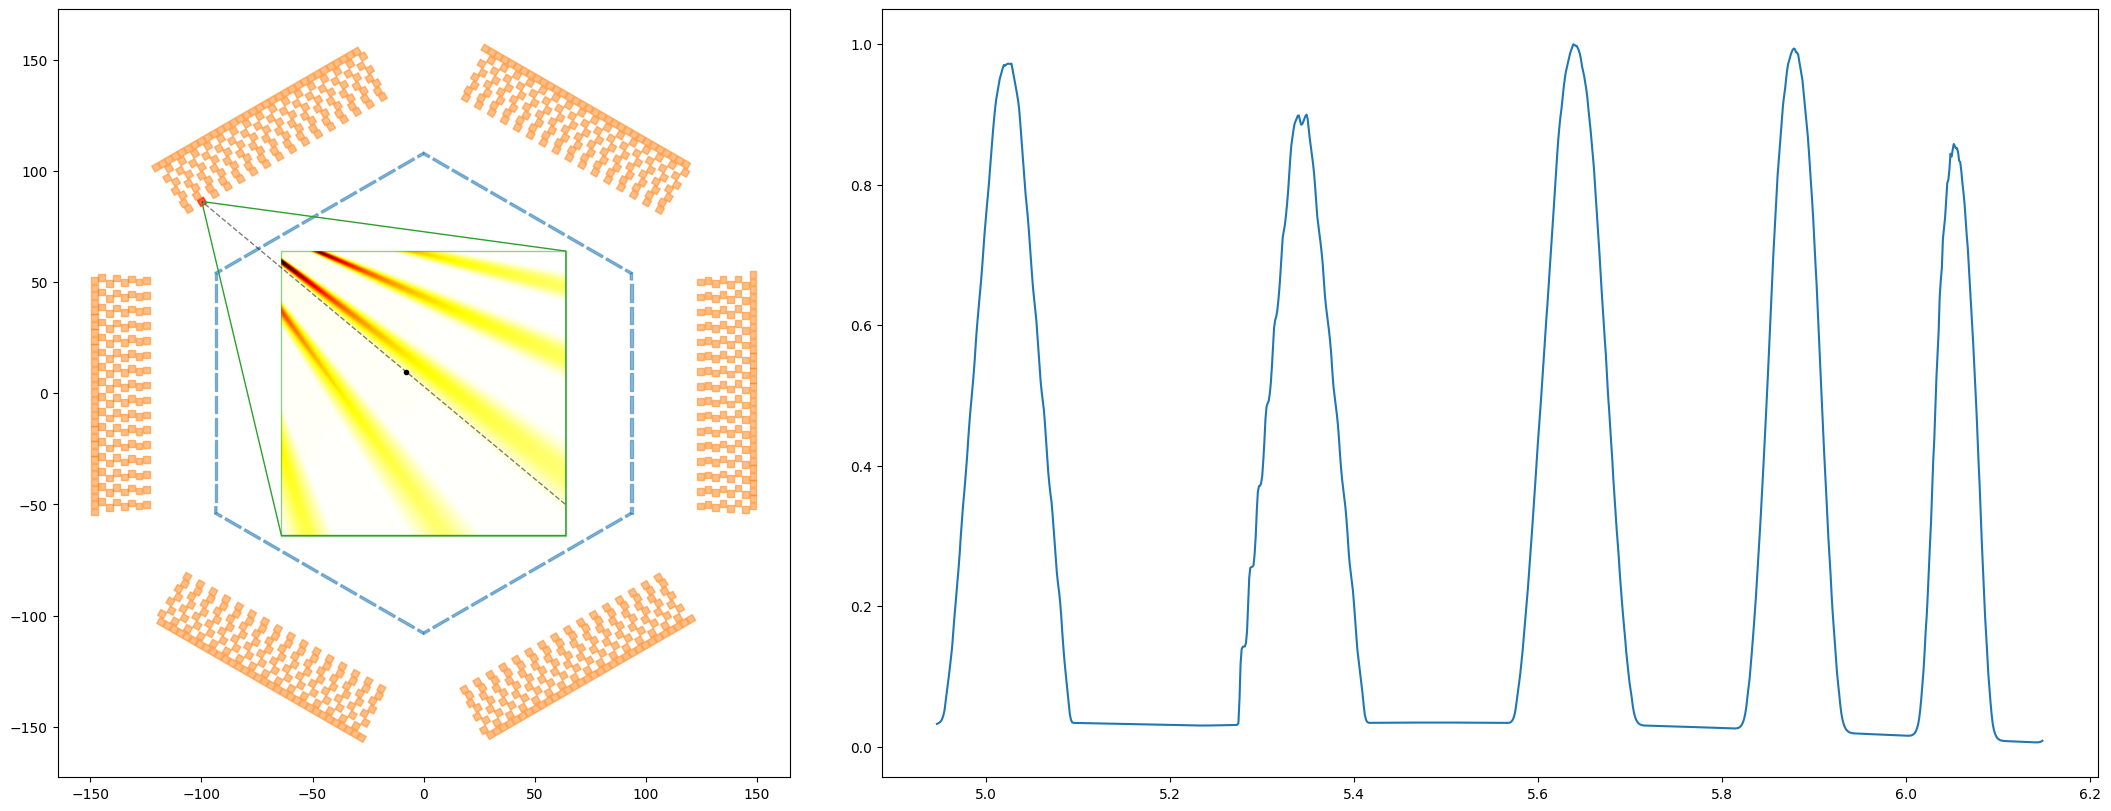

In [24]:
ppdf_data_2d = treated_ppdf_data_2d
# Calculate the convex hull for the crystal
hull_2d = convex_hull_2d(hull_points_batch[selected_crystal_idx])

# Sample the PPDFs on the arc of the convex hull
(sampled_ppdf, sampling_rads, sampling_points) = sample_ppdf_on_arc_2d_local(
    ppdf_data_2d, crystal_centers[selected_crystal_idx], hull_2d, fov_dict
)

relative_sampled_ppdf = sampled_ppdf / sampled_ppdf.max()
beams_boundaries = beams_boundaries_radians(
    relative_sampled_ppdf, sampling_rads, threshold=0.01
)

fov_points_rads = fov_pixels_to_crystal_rads(
    fov_points_xy,
    crystal_centers[selected_crystal_idx],
)

beams_masks = get_beams_masks(
    fov_points_rads,
    beams_boundaries,
)
beams_weighted_centers = get_beams_weighted_center(
    beams_masks,
    fov_points_xy,
    ppdf_data_2d,
)

beams_angles = get_beams_angle_radian(
    beams_weighted_centers,
    crystal_centers[selected_crystal_idx],
)
print(f"N beams: {beams_boundaries.shape[0]}")
plt.close("all")
# Plot the PPDFs and the scanner layout
fig, axs = plt.subplots(
    1,
    2,
    figsize=(21, 8),
    layout="constrained",
    gridspec_kw={"width_ratios": (1, 1.5)},
)

scanner_polycoll = plot_scanner_from_vertices_2d_mpl(
    plate_objects_vertices, crystal_objects_vertices, axs[0], fov_dict
)
selected_crystal_polycoll = plot_polygons_from_vertices_mpl(
    crystal_objects_vertices[selected_crystal_idx].unsqueeze(0),
    axs[0],
    color="red",
    alpha=0.5,
)

hull_mpl_obj = plot_polygons_from_vertices_mpl(
    hull_2d.unsqueeze(0), axs[0], visible=True, fc="none", ec="C2"
)


# ppdf_data_2d = ppdfs[selected_crystal_idx].view(
#     int(fov_dict["n pixels"][0]), int(fov_dict["n pixels"][1])
# )
ppdf_im_obj = plot_2d_ppdf_mpl(
    ppdf_data_2d,
    axs[0],
    fov_dict,
)
axs[0].autoscale()
axs[0].set_aspect("equal")


for center in beams_weighted_centers:
    axs[0].plot(
        center[0].item(),
        center[1].item(),
        "o",
        color="k",
        markersize=3,
        label="Beam center",
    )
    beam_axial_line = axs[0].axline(
        xy1=(center),
        xy2=(crystal_centers[selected_crystal_idx]),
        color="k",
        linestyle="--",
        linewidth=1,
        alpha=0.5,
    )
    beam_axial_line.set_clip_path(
        hull_mpl_obj.get_paths()[0], transform=beam_axial_line.axes.transData
    )

axs[1].plot(sampling_rads, relative_sampled_ppdf, label="Sampled PPDF (relative values)")
for i, boundary in enumerate(beams_boundaries):
    print(f"Boundary {i}: {boundary}")
    # axs[1].axvline(
    #     boundary,
    #     color="C1",
    #     linestyle="--",
    #     linewidth=1,
    #     label=f"Beam {i + 1} boundary",
    # )

In [17]:
print(
    f"Beam angles (deg): {beams_angles * 180 / pi}"
)

Beam angles (deg): tensor([210.1972, 215.9304, 227.7219, 231.9360, 240.9268, 249.9838, 254.7489,
        262.1025, 265.7057])


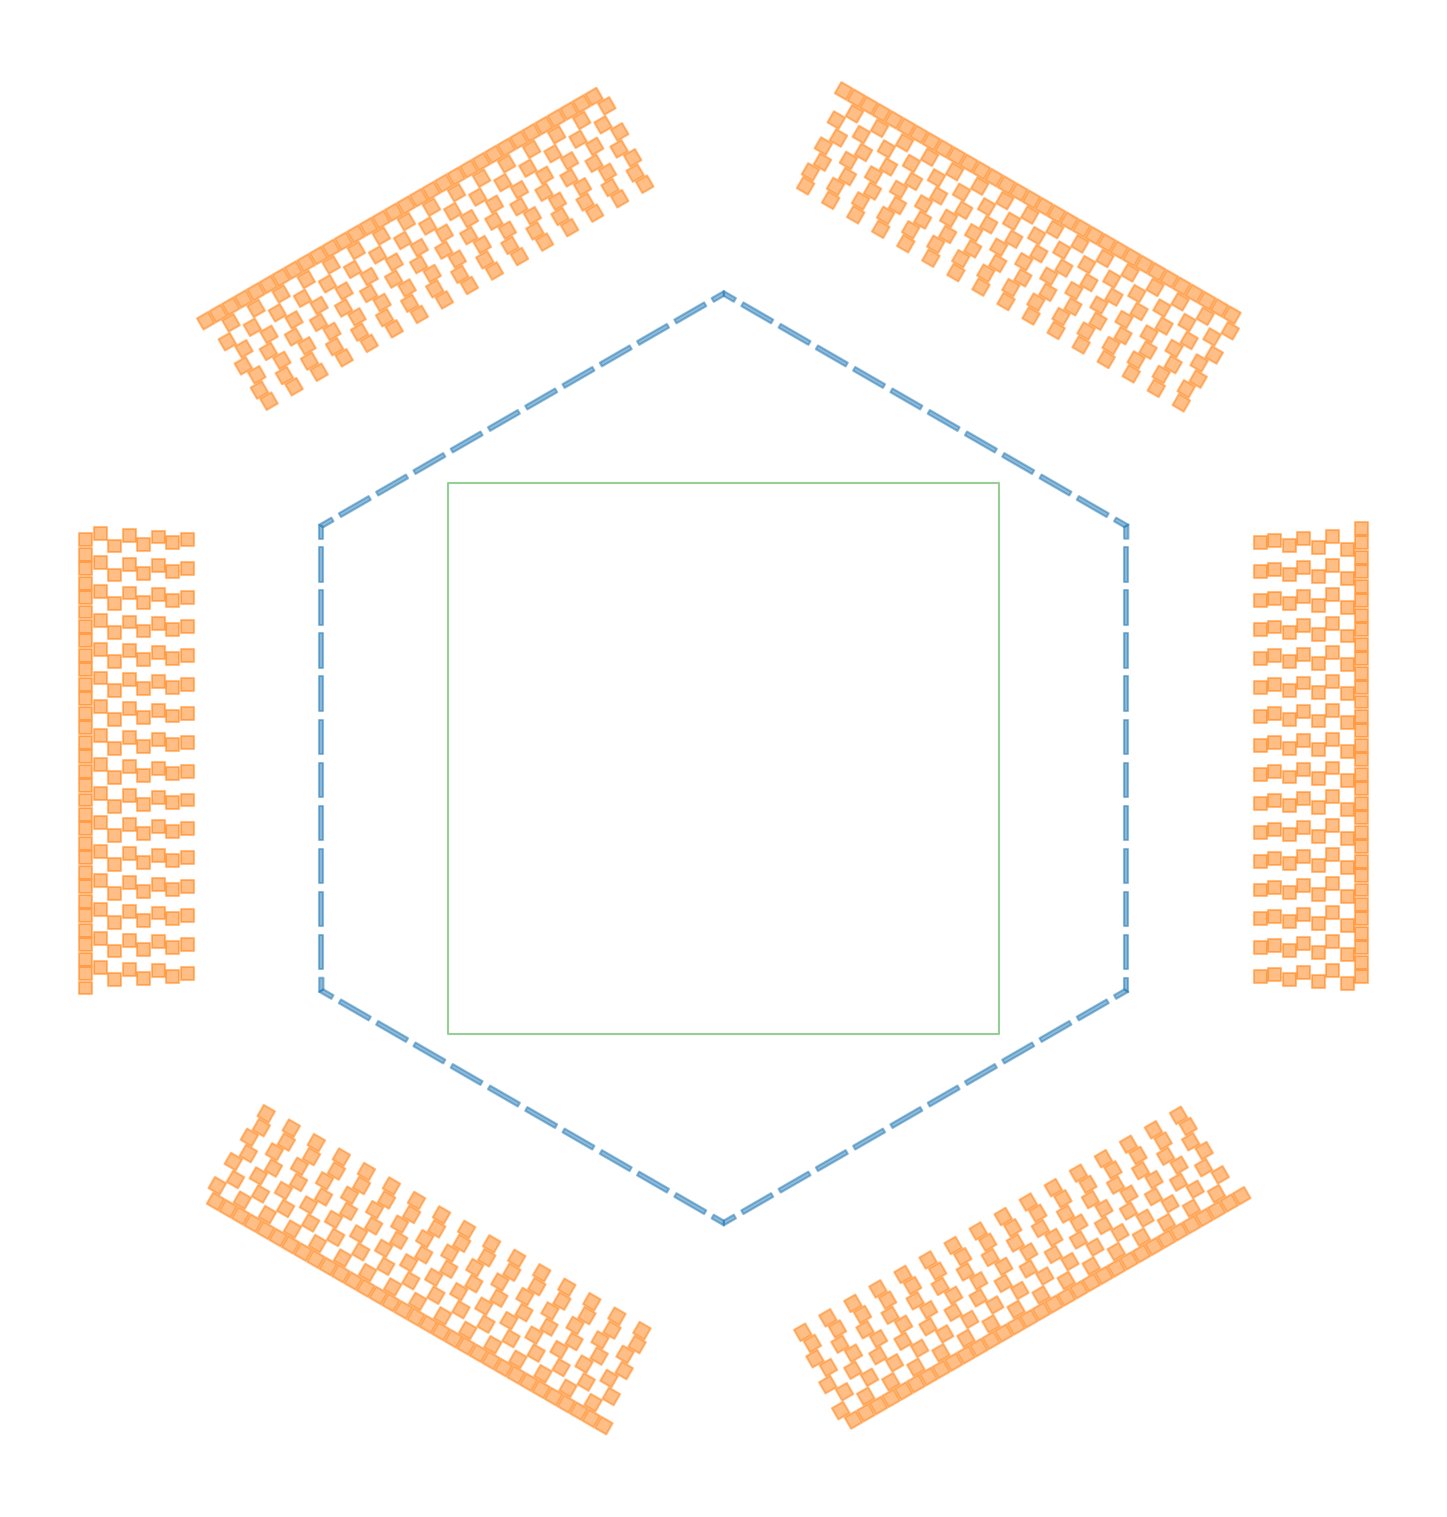

In [30]:
plt.close("all")
# Plot the PPDFs and the scanner layout
fig, ax = plt.subplots(
    1,
    1,
    figsize=(10, 10),
    layout="constrained",
    dpi=150,
)

scanner_polycoll = plot_scanner_from_vertices_2d_mpl(
    plate_objects_vertices, crystal_objects_vertices, ax, fov_dict
)
ax.set_aspect("equal")
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale()
fig.savefig(
    "scanner_layouts_e1531c3444e51439add2f18f5714fc50_layout_0.png",
    transparent=True,
    bbox_inches="tight",
    pad_inches=0.1,
    dpi=150,
)